<a href="https://colab.research.google.com/github/sakuragi-zero/YOASOBI-LLM/blob/master/%E3%83%86%E3%82%AD%E3%82%B9%E3%83%88%E3%81%AE%E5%85%A5%E5%8A%9B.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Transformerにテキストを入力する部分の解説を行います  
これからGPTで使われている手法を解説していきますが、同時に周辺の異なる手法も紹介します  
ぜひ、ネットで調べてみてください  
**※**このノートブックで扱う言語は日本語です  
日本語の特性上、英語と処理などが異なる場合があります  

---

重要な部分は3つ  
- テキストを数値に変換トークン化(**トークナイザ**を使用)
- トークンをベクトルに変換する埋め込み(**Embeding**)
- 単語の並びも情報として与える位置埋め込み(**PositionalEncoding**)

Input Embeddingは以下の順序でテキストを学習可能な数値へ変換します  
1. テキストをトークンに分割  
2. トークンをベクトルに変換  

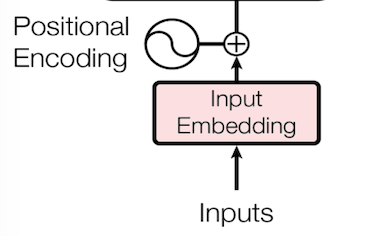

### トークンとは？  
任意に定義されたテキストの単位です  
GPTではサブワード分割の**BPE**を使います
トークン化にはトークナイザを使いますが様々な手法があり**学習ベース**と**ルールベース**のものがあります  

---

**ルールベース**:  
主に単語単位のトークナイザは、辞書や手作業で定めたルールを用いてトークン化します  
そのため、辞書にない新しい単語や表記揺れに弱いという特徴があります

**学習ベース**:  
トークナイザ自体を学習させることで、データから頻出するパターン（語のかけらなど）を獲得します  
これにより、未知の単語や造語にもある程度柔軟に対応できるようになります



| 粒度     | 説明                                         | 例                       | 長所                                  | 短所                                     |
|----------|----------------------------------------------|--------------------------|---------------------------------------|------------------------------------------|
| 単語     | 単語ごとに分割してトークン化する             | teddy bear            | ・理解しやすい<br>・高速に推論できる | ・語彙が大きい<br>・未知語に弱い         |
| サブワード | 単語をさらに小さく分割（**BPE**, WordPiece, SentencePieceなど） | ted ##dy  bear         | ・語彙が小さい<br>・未知語に対応可能 | ・実装が複雑<br>・入力が長くなる         |
| 文字     | 1文字ずつトークン化する                       | t e d d y b e a r        | ・語彙が非常に小さい<br>・未知語なし | ・入力が長い<br>・意味のない表現になる   |
| バイト   | バイト列（ASCIIやUTF）をそのまま扱う          | 116 101<br>100 100<br>121 32 98<br>101 97<br>114 | ・全言語対応<br>・語彙が非常に小さい    | ・入力が長い<br>・解釈が難しい           |


### サブワード分割
サブワード分割とは、文章を「単語」単位ではなく、**意味を持つ単語の一部分（語のかけら）**で分ける方法です

たとえば「テディベア」という言葉をそのまま1語として扱うのではなく、

「テディ」→ 「テッ」「ディ」 のように、よく使われる部分に分けるイメージです

### なぜGPTはBPEを採用しているか？  
- 似た言葉の共通点を見つけやすい  
例：「run」「runner」「running」などは、どれも「run」が元になっています。サブワードなら、こうした関係をうまく捉えられます

- 知らない言葉でも対応しやすい  
例：「bear」と「bears」は少し違うだけです。サブワードに分けると、知らない言葉でも意味のある形で扱えます

### SentencePiece
日本語をサブワード分割しようとすると一度、形態素解析を行う必要があるが、これをやると後列が悪い。
事前の分割処理をなくすために開発されたのがSentencepiceです
BPEの高速化
通常はO(n^2)nはテキスト長
高速化O(N log N)大規模な生文から直接学習・分割が可能
言語モデルによる分割
BPEは辞書に基づく圧縮
言語モデルは尤度を最大化するエントロピー圧縮
※BPEによる貪欲法は分割エラーが見られる

In [1]:
# 必要なライブラリをインストール
! pip install -q tiktoken

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 23.1 MB/s eta 0:00:00


In [27]:
# 実際にテキストをトークン化する
import tiktoken

tokenizer_gpt2 = tiktoken.get_encoding("gpt2")
tokenizer_gpt4 = tiktoken.get_encoding("o200k_base")

text1 = "本山は、足利義満により建立された京都の相国寺"

token_ids1 = tokenizer_gpt2.encode(text1)
token_ids2 = tokenizer_gpt4.encode(text1)

# 分割したままデコード
def split_decode(data):
    try:
        return data.decode('utf-8')
    except UnicodeError:
        return data

# 表示
print("入力文字列:", text1)
print("トークンID:", token_ids1)
print("日本語にデコード:", [split_decode(data) for data in tokenizer_gpt2.decode_tokens_bytes(token_ids1)])
print("トークン数:", len(token_ids1))
print("-" * 10)
print("入力文字列:", text1)
print("トークンID:", token_ids2)
print("日本語にデコード:", [split_decode(data) for data in tokenizer_gpt4.decode_tokens_bytes(token_ids2)])
print("トークン数:", len(token_ids2))

入力文字列: 本山は、足利義満により建立された京都の相国寺
トークンID: [17312, 105, 161, 109, 109, 31676, 23513, 164, 114, 111, 26344, 102, 163, 122, 102, 162, 118, 222, 28618, 1792, 230, 28255, 161, 119, 118, 44165, 233, 43357, 39258, 25224, 12859, 105, 32849, 121, 17683, 249, 116, 32368, 121, 43380, 118]
[b'\xe6\x9c', b'\xac', b'\xe5', b'\xb1', b'\xb1', 'は', '、', b'\xe8', b'\xb6', b'\xb3', b'\xe5\x88', b'\xa9', b'\xe7', b'\xbe', b'\xa9', b'\xe6', b'\xba', b'\x80', 'に', b'\xe3\x82', b'\x88', 'り', b'\xe5', b'\xbb', b'\xba', b'\xe7\xab', b'\x8b', 'さ', 'れ', 'た', b'\xe4\xba', b'\xac', b'\xe9\x83', b'\xbd', b'\xe3\x81\xae\xe7', b'\x9b', b'\xb8', b'\xe5\x9b', b'\xbd', b'\xe5\xaf', b'\xba']
トークン数: 41
----------
入力文字列: 本山は、足利義満により建立された京都の相国寺
トークンID: [4087, 11767, 5205, 1395, 16527, 7436, 114735, 103646, 5280, 67023, 95444, 188599, 62110, 3385, 11949, 3052, 136873]
['本', '山', 'は', '、', '足', '利', '義', '満', 'に', 'より', '建立', 'された', '京都', 'の', '相', '国', '寺']
トークン数: 17


In [26]:
# 分割したままデコード
# エンコード
tokens = tokenizer_gpt4.encode("こんにちは、世界！")
print(len(tokens))
print(tokens)

# 分割したままデコード
def split_decode(data):
    try:
        return data.decode('utf-8')
    except UnicodeError:
        return data
        print([data2str(data) for data in tokenizer_gpt4.decode_tokens_bytes(tokens)])

4
[95839, 1395, 28428, 3393]
['こんにちは', '、', '世界', '！']


### [コラム]：形態素解析を使ったトークン化
日本語は英語と異なり、単語の境界が明確でないため、単純なスペース分割ではトークン化が難しくなります。このため、以下のような形態素解析ツールが利用されます

- MeCab（高精度で広く使われる）

- Sudachi（分割粒度を調整可能で大規模データ向け）

- Janome（Python向けで手軽に使える）
他のもGinzaやvibratoなど様々な形態素解析ツールがある

長所:

文法的な情報（品詞など）も取得可能。

固有名詞の適切な処理が可能。

短所:

学習済み辞書に依存するため、新語の処理が難しい。

英語のようなサブワードベースの手法（BPE等）と比較すると柔軟性が低い